=== METRIK TERHADAP CITRA ORIGINAL ===
Gaussian Blur Spasial (sigma=3)
MSE=0.002715 | PSNR=25.66 dB | SSIM=0.7938

Gaussian LPF Frekuensi (cutoff=10)
MSE=0.007751 | PSNR=21.11 dB | SSIM=0.6839

Gaussian LPF Frekuensi (cutoff=30)
MSE=0.003696 | PSNR=24.32 dB | SSIM=0.7512

Gaussian LPF Frekuensi (cutoff=60)
MSE=0.002042 | PSNR=26.90 dB | SSIM=0.8421



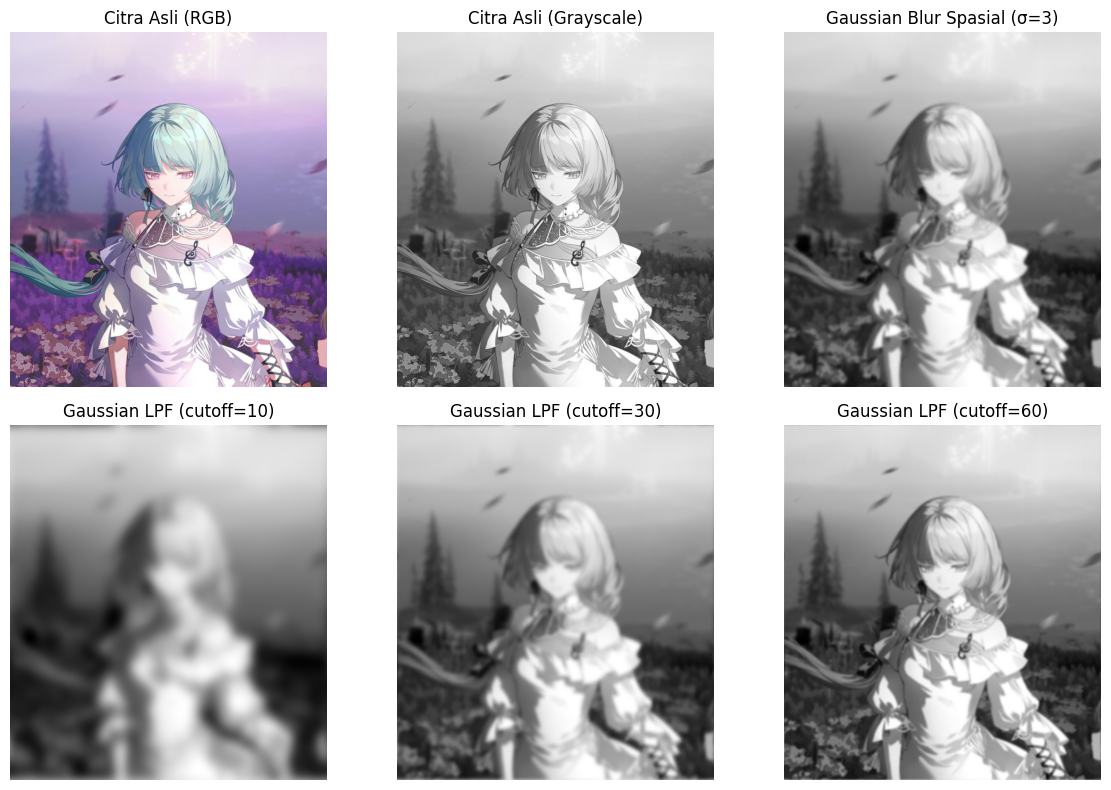

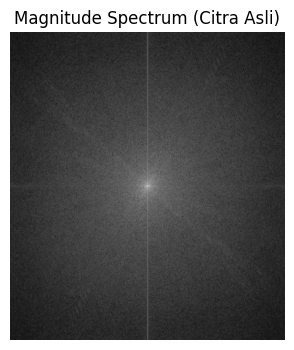

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# ---------------------------------------------------
# 1. LOAD CITRA
# ---------------------------------------------------
# Pastikan file 'phrolova.jpeg' ada di folder kerja
img = cv2.imread('assets/phrolova.jpeg')

# OpenCV baca dalam BGR → ubah ke RGB & grayscale
img_rgb  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Normalisasi ke [0,1] agar metrik aman
img_gray_f = img_gray.astype(np.float32) / 255.0

# ---------------------------------------------------
# 2. GAUSSIAN BLUR (DOMAIN SPASIAL)
# ---------------------------------------------------
sigma_spatial = 3  # boleh diganti sesuai tugas

blur_spatial = cv2.GaussianBlur(
    img_gray_f,
    ksize=(0, 0),
    sigmaX=sigma_spatial
)

# ---------------------------------------------------
# 3. GAUSSIAN LPF DOMAIN FREKUENSI
# ---------------------------------------------------
def gaussian_lpf_shape(shape, cutoff):
    M, N = shape
    u = np.arange(M)
    v = np.arange(N)
    U, V = np.meshgrid(u, v, indexing='ij')

    # Shift pusat frekuensi ke tengah
    D2 = (U - M/2)**2 + (V - N/2)**2
    H = np.exp(-D2 / (2 * (cutoff**2)))
    return H

def apply_frequency_gaussian_lpf(img_f, cutoff):
    F = np.fft.fft2(img_f)
    F_shift = np.fft.fftshift(F)

    H = gaussian_lpf_shape(img_f.shape, cutoff)
    G_shift = F_shift * H
    G = np.fft.ifftshift(G_shift)
    g = np.fft.ifft2(G)
    g = np.real(g)

    magnitude_spectrum = np.log(1 + np.abs(F_shift))
    return g, magnitude_spectrum, H

cutoffs = [10, 30, 60]
blur_freq_results = {}
mag_spectrum = None

for c in cutoffs:
    g, mag, H = apply_frequency_gaussian_lpf(img_gray_f, cutoff=c)
    blur_freq_results[c] = g
    if mag_spectrum is None:
        mag_spectrum = mag

# ---------------------------------------------------
# 4. METRIK MSE, PSNR, SSIM
# ---------------------------------------------------
def mse(img1, img2):
    return np.mean((img1 - img2)**2)

def psnr(img1, img2):
    m = mse(img1, img2)
    if m == 0:
        return float('inf')
    MAX_I = 1.0
    return 10 * np.log10((MAX_I**2) / m)

def calc_metrics(ref, test):
    return mse(ref, test), psnr(ref, test), ssim(ref, test, data_range=1.0)

print("=== METRIK TERHADAP CITRA ORIGINAL ===")

# Spasial
m_sp, p_sp, s_sp = calc_metrics(img_gray_f, blur_spatial)
print(f"Gaussian Blur Spasial (sigma={sigma_spatial})")
print(f"MSE={m_sp:.6f} | PSNR={p_sp:.2f} dB | SSIM={s_sp:.4f}\n")

# Frekuensi
for c in cutoffs:
    m_f, p_f, s_f = calc_metrics(img_gray_f, blur_freq_results[c])
    print(f"Gaussian LPF Frekuensi (cutoff={c})")
    print(f"MSE={m_f:.6f} | PSNR={p_f:.2f} dB | SSIM={s_f:.4f}\n")

# ---------------------------------------------------
# 5. VISUALISASI
# ---------------------------------------------------
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(img_rgb)
plt.title("Citra Asli (RGB)")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(img_gray, cmap='gray')
plt.title("Citra Asli (Grayscale)")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(blur_spatial, cmap='gray')
plt.title(f"Gaussian Blur Spasial (σ={sigma_spatial})")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(blur_freq_results[10], cmap='gray')
plt.title("Gaussian LPF (cutoff=10)")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(blur_freq_results[30], cmap='gray')
plt.title("Gaussian LPF (cutoff=30)")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(blur_freq_results[60], cmap='gray')
plt.title("Gaussian LPF (cutoff=60)")
plt.axis('off')

plt.tight_layout()
plt.show()

# Magnitude Spectrum
plt.figure(figsize=(5, 4))
plt.imshow(mag_spectrum, cmap='gray')
plt.title("Magnitude Spectrum (Citra Asli)")
plt.axis('off')
plt.show()
